In [1]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords


2018-05-04 08:25:55,774 : INFO : 'pattern' package not found; tag filters are not available for English
/home/nikita/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv('/home/nikita/PycharmProjects/natural_language/data/test_prepocess.csv')
data.head()

,stars,text,useful,funny
0,3,The good: mini doughnuts and americano friendl...,1,0
1,3,I really like the décor of the place and the w...,0,0
2,5,"Great service, clean and great food, this plac...",1,0
3,5,This place has never failed on me! \nLate nigh...,0,0
4,2,This is a fast food spin off from Paramount Fi...,1,1


In [40]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)

In [41]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')
    
def plot_confusion_matrix(cm, title='Матрица ошибок', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    my_tags = pd.unique(data.stars)
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('Исходные метки')
    plt.xlabel('Полученные метки')

def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data.text)
    predictions = classifier.predict(data_features)
    target = data.stars
    evaluate_prediction(predictions, target)

In [57]:
%%time
n_gram_vectorizer = HashingVectorizer(
    analyzer="char",
    ngram_range=([2,5]),
    tokenizer=None,
    n_features=3000,
    preprocessor=None)

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

CPU times: user 35 µs, sys: 0 ns, total: 35 µs
Wall time: 40.3 µs


In [58]:
train_batch = train_data[0:3000]

In [59]:
%%time
tf_vect = TfidfVectorizer(
    min_df=2, tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english')
train_data_features = tf_vect.fit_transform(train_batch.text)

CPU times: user 3.33 s, sys: 0 ns, total: 3.33 s
Wall time: 3.33 s


In [53]:
print(len(tf_vect.get_feature_names()))
tf_vect.get_feature_names()[500:520]

7929


['anger',
 'angrily',
 'angry',
 'animal',
 'animals',
 'anniversary',
 'annoyed',
 'annoying',
 'annual',
 'anonymous',
 'answer',
 'answered',
 'answering',
 'answers',
 'anthony',
 'antibiotics',
 'anticipated',
 'anticipating',
 'anticipation',
 'antipasto']

In [56]:
%%time
train_data_features = n_gram_vectorizer.fit_transform(tf_vect.get_feature_names())

CPU times: user 115 ms, sys: 21 µs, total: 115 ms
Wall time: 114 ms


In [60]:
%%time
logreg = linear_model.LogisticRegression(n_jobs=3, C=1e5)
logreg = logreg.fit(train_data_features, train_batch.stars)

/home/nikita/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 3.
  " = {}.".format(self.n_jobs))


CPU times: user 618 ms, sys: 28.1 ms, total: 646 ms
Wall time: 509 ms


accuracy 0.5473136058688257
confusion matrix
 [[ 9189  1475   989  1214  1531]
 [ 2356  1516  1740  1820  1190]
 [ 1162  1332  2824  4416  2606]
 [  662   844  2423 10059 10675]
 [  817   560  1211  8615 34008]]
(row=expected, col=predicted)
CPU times: user 1min 54s, sys: 148 ms, total: 1min 55s
Wall time: 1min 55s


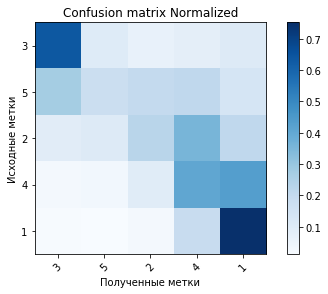

In [61]:
%%time
predict(tf_vect, logreg, test_data)